In [3]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import random as rand

In [6]:
class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        self.node_num = 12
        self.learning_rate = 0.001
        self.epochs_cnt = 5               
        self.model = self.build_model()        
        
        self.discount_rate = 0.97
        self.penalty = -100

        self.episode_num = 500        
        
        self.replay_memory_limit = 2048
        self.replay_size = 32
        self.replay_memory = []

        self.epsilon = 0.99
        self.epsilon_decay = 0.2 # 0.2 episode의 20%가되면 수행되면  epsilon이 0이 된다.
        self.epsilon_min = 0.05
        
        self.moving_avg_size = 20
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
    def build_model(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        x = (input_states)
        x = Dense(self.node_num, activation='relu')(x)
        out_actions = Dense(self.action_size, activation='linear', name='output')(x)
        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_actions])
        model.compile(optimizer=Adam(lr=self.learning_rate),
                      loss='mean_squared_error'
                     )
        model.summary()
        return model

    def train(self):
        for episode in range(self.episode_num):
            state = self.env.reset()
            state = state[0] #최초 dictionary 형태 생성
            Q, count, reward_tot = self.take_action_and_append_memory(episode, state)

            if count < 500:
                reward_tot = reward_tot-self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            
            self.train_mini_batch(Q)
                
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def take_action_and_append_memory(self, episode, state):
        reward_tot = 0
        count = 0
        done = False
        episilon = self.get_episilon(episode)
        while not done:
            count+=1
            state_t = np.reshape(state,[1, 1, self.state_size])
            Q = self.model.predict(state_t)
            action = self.greed_search(episilon, episode, Q)
            state_next, reward, done, none, none2 = self.env.step(action) #2022.12.10 gym version upgrade 후 return 값 5개로 변경
            
            if done:
                reward = self.penalty 
            self.replay_memory.append([state_t, action, reward, state_next, done])
            if len(self.replay_memory) > self.replay_memory_limit:
                del self.replay_memory[0]
            reward_tot += reward
            state = state_next
        return Q, count, reward_tot

    def train_mini_batch(self, Q):
        array_state = []
        array_Q = []
        this_replay_size = self.replay_size
        if len(self.replay_memory) < self.replay_size:
            this_replay_size = len(self.replay_memory)
        
        for sample in rand.sample(self.replay_memory, this_replay_size):
            state_t,action,reward,state_next,done = sample
            if done:
                Q[0, 0, action] = reward
            else:
                state_t= np.reshape(state_next,[1,1,self.state_size])
                Q_new = self.model.predict(state_t)
                Q[0, 0, action] = reward + self.discount_rate * np.max(Q_new)
            array_state.append(state_t.reshape(1,self.state_size))
            array_Q.append(Q.reshape(1,self.action_size))
        array_state_t = np.array(array_state)
        array_Q_t = np.array(array_Q)
        hist = self.model.fit(array_state_t, array_Q_t, epochs=self.epochs_cnt, verbose=0)    

    def get_episilon(self, episode):
        result = self.epsilon * ( 1 - episode/(self.episode_num*self.epsilon_decay) )
        if result < self.epsilon_min:
            result = self.epsilon_min
        return result

    def greed_search(self, episilon, episode, Q):  
        if episilon > np.random.rand(1):
            action = self.env.action_space.sample()
        else:
            action = np.argmax(Q)
        return action

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/dqn")
        print("*****end learing")

In [7]:
if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_states (InputLayer)    [(None, 1, 4)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 12)             60        
_________________________________________________________________
output (Dense)               (None, 1, 2)              26        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
episode:0, moving_avg:24.0, rewards_avg:23.0
episode:10, moving_avg:17.181818181818183, rewards_avg:16.181818181818183
episode:20, moving_avg:21.85, rewards_avg:20.952380952380953
episode:30, moving_avg:25.75, rewards_avg:21.70967741935484
episode:40, moving_avg:19.6, rewards_avg:19.804878048780488
episode:50, moving_avg:13.5, rewards_avg:18.098039215686274
episode:60, moving_avg:13.9, rewa

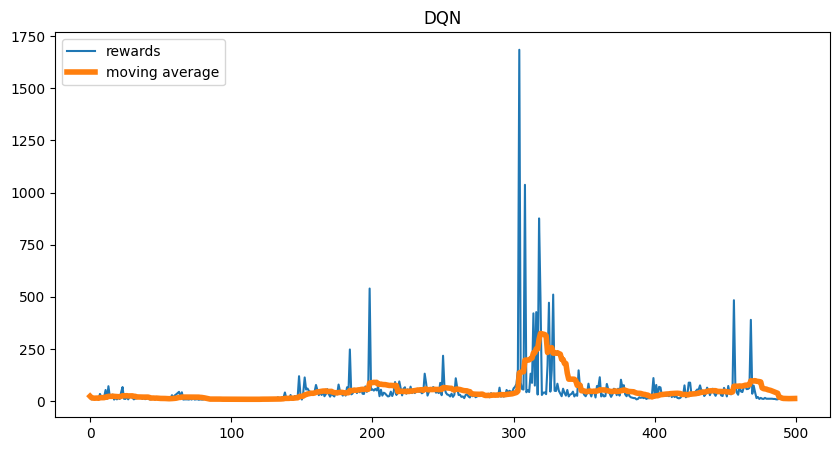

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('DQN')
plt.show()